done by: https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

In [79]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [49]:
df = pd.read_csv('./data/2019_opens_clean.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [50]:
# Add a feature with random values to interpret results
np.random.seed(seed = 42)
df['RANDOM'] = np.random.normal(size = len(df))

In [51]:
# dataframe without benchmarks or height & weight
scores_cols = ['competitorid', 'gender', 'age', 'overallrank', 'is_scaled', \
               'scaled_1', 'scaled_2', 'scaled_3', 'scaled_4', 'scaled_5', \
               'time_2','time_3','time_4','time_5', \
               'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', 'w2_reps_du', \
               'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', 'w3_reps_total', \
               'w3_hspu_status', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
               'w4_bmu_status', 'w4_tiebreak', 'w5_reps_total', 'RANDOM']
df_scores = df[scores_cols]

In [52]:
# drop rows with missing age values
df_scores = df_scores[df_scores['age'].notna()]
# keep just rows with all 5 workouts participated
df_scores = df_scores[df_scores['w1_reps_total'].notna()]
df_scores = df_scores[df_scores['w2_reps_total'].notna()]
df_scores = df_scores[df_scores['w3_reps_total'].notna()]
df_scores = df_scores[df_scores['w4_reps_total'].notna()]
df_scores = df_scores[df_scores['w5_reps_total'].notna()]
# drop rows with missing time values
df_scores = df_scores[df_scores['time_2'].notna()]
df_scores = df_scores[df_scores['time_3'].notna()]
df_scores = df_scores[df_scores['time_4'].notna()]
df_scores = df_scores[df_scores['time_5'].notna()]
# set missing tiebreak values to zero
df_scores['w2_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w3_tiebreak'].replace(np.NaN,0,inplace=True)
df_scores['w4_tiebreak'].replace(np.NaN,0,inplace=True)
# replace categorical values with integer 1/0
df_scores['gender'].replace(['M','F'],[1,0],inplace=True)
df_scores['w3_hspu_status'].replace([1.0,0.0],[1,0],inplace=True)
df_scores['w4_bmu_status'].replace([1.0,0.0],[1,0],inplace=True)

In [53]:
train_set_sc, test_set_sc = train_test_split(df_scores, test_size=0.3, random_state=42)

In [54]:
y_sc = df_scores['overallrank']
X_sc = df_scores.drop(axis=1,columns='overallrank')

In [55]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, random_state=42)

In [56]:
scale_cols = ['competitorid','gender','age','time_2','time_3', \
              'time_4', 'time_5', 'w1_reps_total', 'w2_reps_total', 'w2_reps_t2b', \
              'w2_reps_du', 'w2_reps_sqcl', 'w2_rounds_completed', 'w2_tiebreak', \
              'w3_reps_total', 'w3_tiebreak', 'w4_reps_total', 'w4_reps_bmu', \
              'w4_tiebreak', 'w5_reps_total'
             ]

In [57]:
scaler = StandardScaler()
X_train_scaled_sc = scaler.fit_transform(X_train_sc[scale_cols])
X_test_scaled_sc = scaler.transform(X_test_sc[scale_cols])

In [58]:
X_train_preprocessed_sc = np.concatenate([X_train_scaled_sc, X_train_sc.drop(scale_cols, axis=1)], axis=1)
X_test_preprocessed_sc = np.concatenate([X_test_scaled_sc, X_test_sc.drop(scale_cols, axis=1)], axis=1)

### Benchmark Model

In [62]:
rf = RandomForestRegressor(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train_sc, y_train_sc)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

In [63]:
print('R^2 Training Score: {:.4f} \nOOB Score: {:.4f} \nR^2 Validation Score: {:.4f}'.format(rf.score(X_train_sc, y_train_sc), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test_sc, y_test_sc)))

R^2 Training Score: 0.9997 
OOB Score: 0.9981 
R^2 Validation Score: 0.9981


### Overall Feature Importance

#### Scikit-learn's feature importance

In [64]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

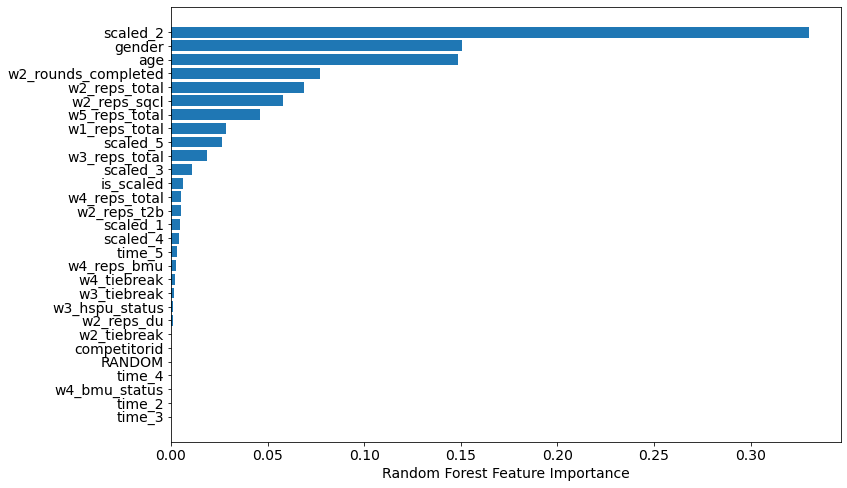

In [66]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_sc.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

#### Permutation feature importance

In [82]:
perm_importance = permutation_importance(rf, X_test_preprocessed_sc, y_test_sc)

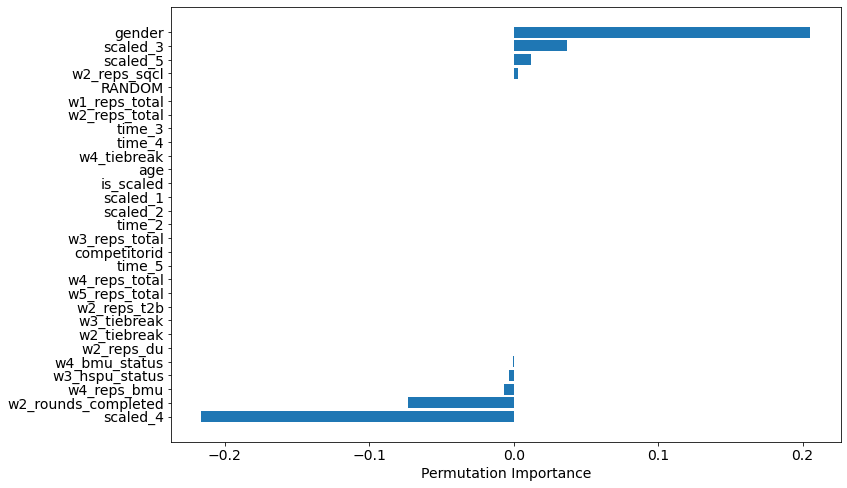

In [84]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_sc.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

#### Drop column feature importance